In [1]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.7 MB/s eta 0:00:00


In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid, ParameterSampler
import time
import json
import pickle
from functools import partial
import random
from datetime import datetime

In [79]:
from utils import FinancialDataHandler
from model import PredictionModel, TimeSeriesDataset, StackedLSTMModel, AttentionLayer

In [94]:
print("Starting prediction model training and evaluation with PyTorch")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Create directories
model_save_path =f'./model/{timestamp}'

os.makedirs(f'{model_save_path}', exist_ok=True)
os.makedirs(f'{model_save_path}/data', exist_ok=True)
os.makedirs(f'{model_save_path}/models', exist_ok=True)
os.makedirs(f'{model_save_path}/results', exist_ok=True)
os.makedirs(f'{model_save_path}/plots', exist_ok=True)

# name and ticker
ticker_info = {'EURUSD': 'EURUSD=X'}

# date range
start_date = '2010-01-01'
end_date = None

# Fetch and preprocess data
data_handler = FinancialDataHandler(
    ticker_info=ticker_info,
    start_date=start_date,
    end_date=end_date,
    window_size=30,
    train_split=0.8,
    model_save_path=model_save_path
)

processed_data = data_handler.fetch_and_preprocess_data()


Starting prediction model training and evaluation with PyTorch
Fetching EURUSD data from 2010-01-01 to 2025-04-01
Raw data saved to ./model/2025-04-01_09-03-21/data/EURUSD=X_raw.csv
Calculating technical indicators
Technical indicators calculated
Preprocessing data
Preprocessed data saved. X_train shape: (3137, 30, 20), y_train shape: (3137,)
X_test shape: (785, 30, 20), y_test shape: (785,)


Using device: cpu
Starting hyperparameter optimization analysis with PyTorch
Starting Random Search with 10 iterations
Iteration 1/10: Testing {'learning_rate': 0.001, 'hidden_size_3': 16, 'hidden_size_2': 64, 'hidden_size_1': 256, 'dropout_rate': 0.3, 'batch_size': 32}
Validation loss: 0.037142, Training time: 63.31s
New best parameters found: {'learning_rate': 0.001, 'hidden_size_3': 16, 'hidden_size_2': 64, 'hidden_size_1': 256, 'dropout_rate': 0.3, 'batch_size': 32} with validation loss: 0.037142
Iteration 2/10: Testing {'learning_rate': 0.0005, 'hidden_size_3': 32, 'hidden_size_2': 64, 'hidden_size_1': 256, 'dropout_rate': 0.2, 'batch_size': 16}
Validation loss: 0.031912, Training time: 48.52s
New best parameters found: {'learning_rate': 0.0005, 'hidden_size_3': 32, 'hidden_size_2': 64, 'hidden_size_1': 256, 'dropout_rate': 0.2, 'batch_size': 16} with validation loss: 0.031912
Iteration 3/10: Testing {'learning_rate': 0.0001, 'hidden_size_3': 32, 'hidden_size_2': 32, 'hidden_size_

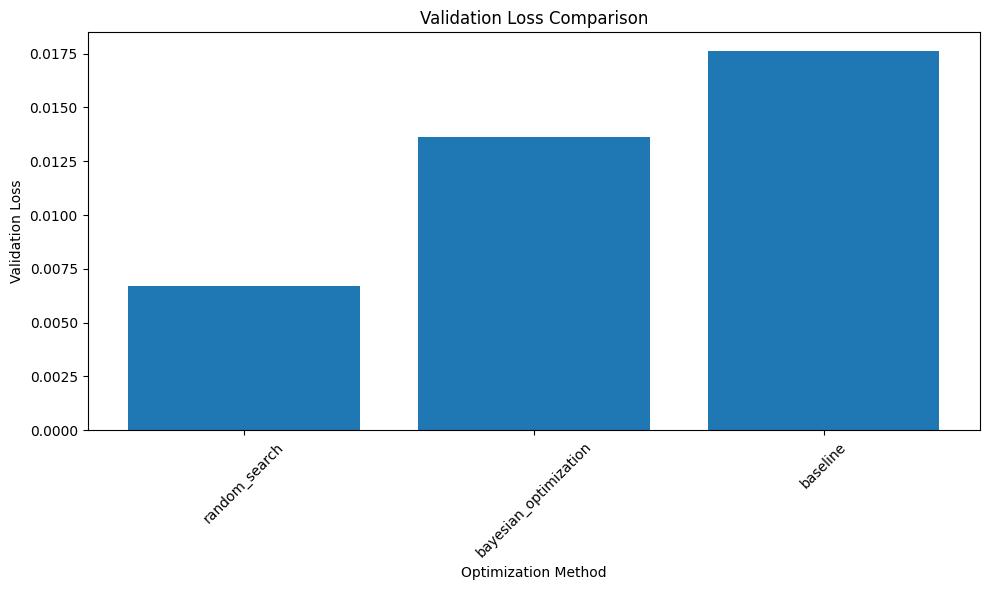

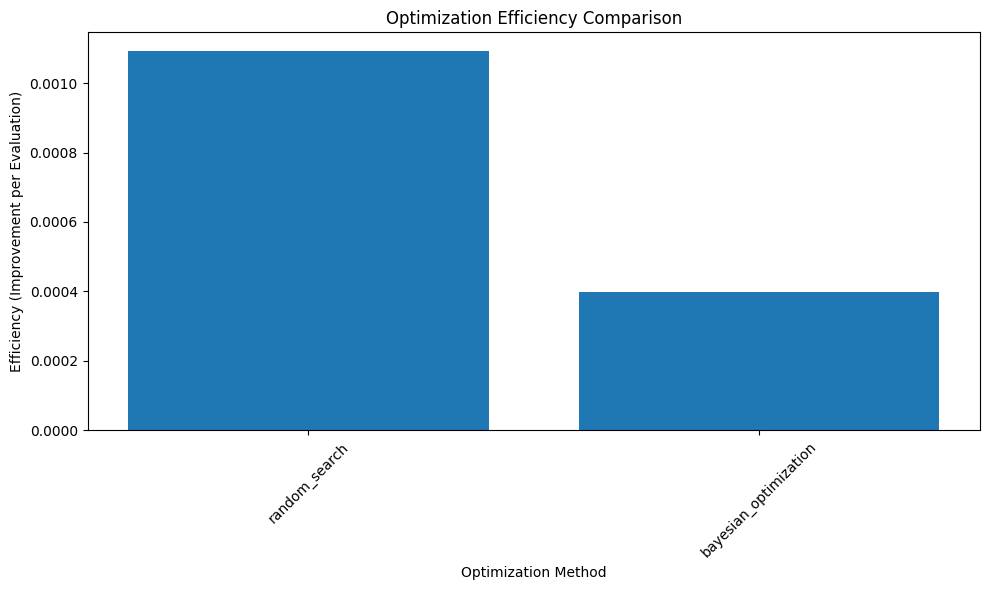

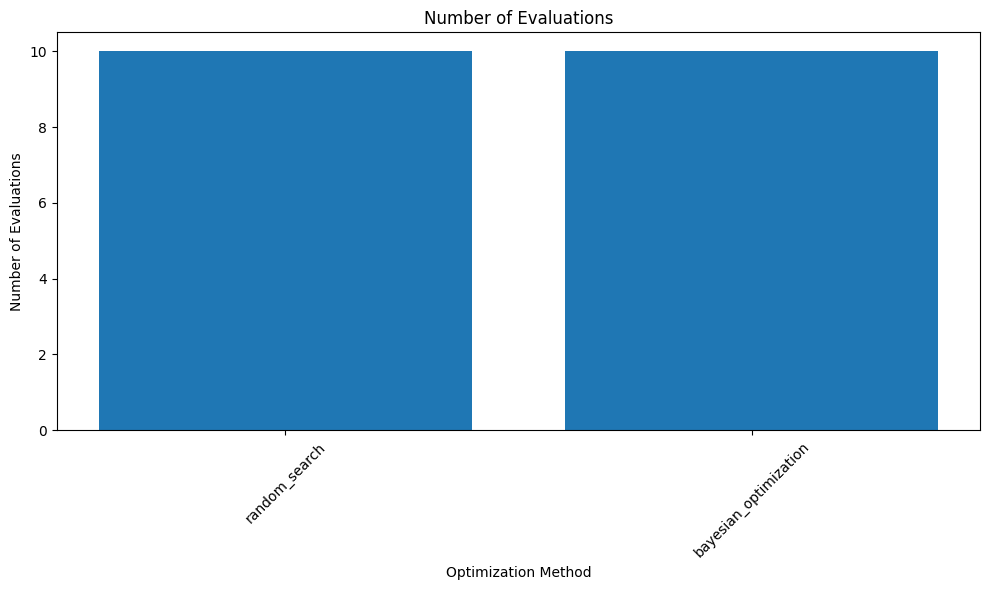

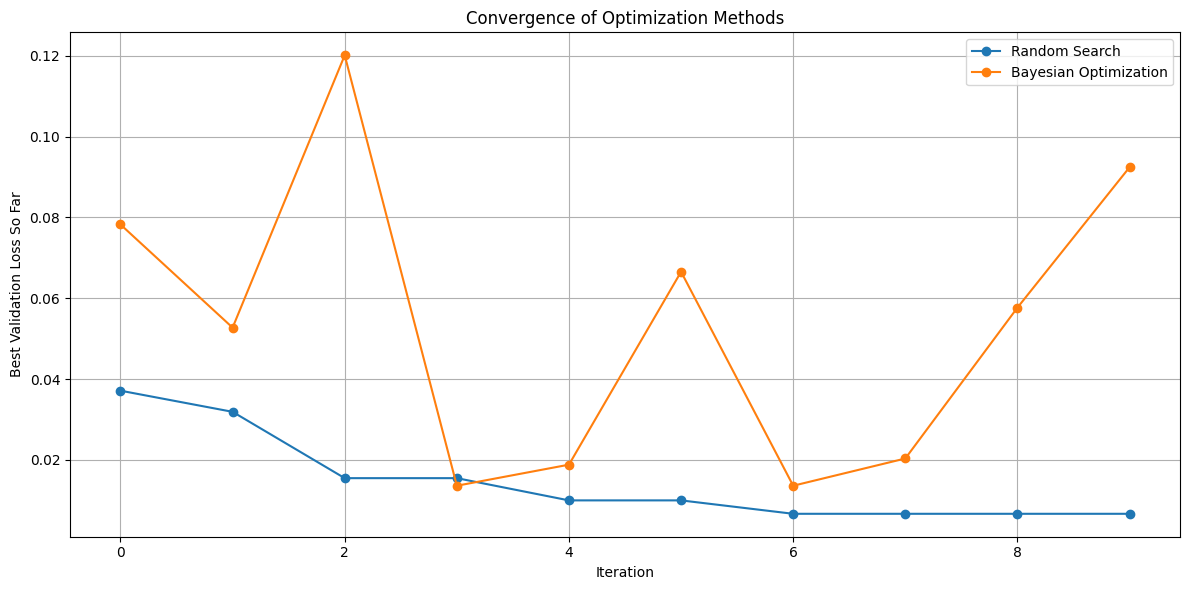

In [98]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Create directories
os.makedirs(f'{model_save_path}/pytorch_hyperparameter_optimization', exist_ok=True)
os.makedirs(f'{model_save_path}/pytorch_hyperparameter_optimization/results', exist_ok=True)
os.makedirs(f'{model_save_path}/pytorch_hyperparameter_optimization/plots', exist_ok=True)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class HyperparameterOptimization:
    """
    Class for hyperparameter optimization of PyTorch LSTM models
    """
    def __init__(self, data, device, save_dir='pytorch_hyperparameter_optimization'):
        """
        Initialize the optimizer

        Parameters:
        -----------
        data : dict
            Dictionary containing training data
        save_dir : str
            Directory to save results
        """
        self.data = data
        self.input_size = data['X_train'].shape[2]
        self.device = device

        self.save_dir = save_dir

        # Dictionary to store results from different methods
        self.optimization_results = {}


    def _train_model(self, model, batch_size=32, epochs=20, patience=5, learning_rate=0.001):
        """
        Train the model with optimized hyperparameters

        Parameters:
        -----------
        model: Pytorch Model
        batch_size : int
            Batch size for training
        epochs : int
            Maximum number of epochs
        patience : int
            Patience for early stopping
        learning_rate : float
            Learning rate for the optimizer

        Returns:
        --------
        best_val_loss : float
            Best validation loss
        training_time : float
            Training time om seconds
        """

        # Create data loaders
        train_dataset = TimeSeriesDataset(self.data['X_train'], self.data['y_train'])
        val_size = int(0.2 * len(train_dataset))
        train_size = len(train_dataset) - val_size

        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

        train_loader = DataLoader(
            train_subset,
            batch_size=batch_size,
            shuffle=True
        )

        val_loader = DataLoader(
            val_subset,
            batch_size=batch_size,
            shuffle=False
        )

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Early stopping variables
        best_val_loss = float('inf')
        early_stopping_counter = 0
        best_model_state = None

        start_time = time.time()

        # Training loop
        for epoch in range(epochs):
            # Train mode
            model.train()
            train_loss = 0.0

            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                optimizer.zero_grad()

                outputs, _ = model(batch_X, apply_dropout=True)

                loss = criterion(outputs, batch_y)

                loss.backward()
                optimizer.step()

                train_loss += loss.item() * batch_X.size(0)

            train_loss = train_loss / len(train_loader.dataset)

            # Validation
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                    outputs, _ = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item() * batch_X.size(0)

            val_loss = val_loss / len(val_loader.dataset)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    break

        # Record end time
        end_time = time.time()
        training_time = end_time - start_time

        return best_val_loss, training_time

    def random_search(self, param_distributions, n_iter=10, epochs=20, patience=5):
        """
        Perform random search for hyperparameter optimization

        Parameters:
        -----------
        param_distributions : dict
            Dictionary of parameter distributions
        n_iter : int
            Number of random combinations to try
        epochs : int
            Maximum number of epochs for each model
        patience : int
            Patience for early stopping

        Returns:
        --------
        best_params : dict
            Best parameters found
        """
        print(f"Starting Random Search with {n_iter} iterations")

        # Create random parameter combinations
        param_sampler = ParameterSampler(param_distributions, n_iter=n_iter, random_state=42)
        param_combinations = list(param_sampler)

        results = []
        best_val_loss = float('inf')
        best_params = None

        for i, params in enumerate(param_combinations):
            print(f"Iteration {i+1}/{n_iter}: Testing {params}")

            # Create model with current parameters
            model = StackedLSTMModel(
                input_size=self.input_size,
                hidden_size_1=params.get('hidden_size_1', 128),
                hidden_size_2=params.get('hidden_size_2', 64),
                hidden_size_3=params.get('hidden_size_3', 32),
                dropout_rate=params['dropout_rate']
            ).to(device)

            # Train and evaluate model
            val_loss, training_time = self._train_model(
                model,
                batch_size=params['batch_size'],
                epochs=epochs,
                patience=patience,
                learning_rate=params['learning_rate']
            )

            result = {
                'params': params,
                'val_loss': val_loss,
                'training_time': training_time
            }
            results.append(result)

            print(f"Validation loss: {val_loss:.6f}, Training time: {training_time:.2f}s")

            # Update best parameters if current model is better
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = params
                print(f"New best parameters found: {best_params} with validation loss: {best_val_loss:.6f}")

        # Save results
        with open(os.path.join(self.save_dir, 'results', 'random_search_results.json'), 'w') as f:
            json.dump([{**r, 'params': dict(r['params'])} for r in results], f, indent=4)

        # Store results for comparison
        self.optimization_results['random_search'] = {
            'best_params': dict(best_params),
            'best_val_loss': best_val_loss,
            'all_results': [{**r, 'params': dict(r['params'])} for r in results],
            'num_evaluations': n_iter
        }

        print(f"\nRandom search completed. Best parameters: {best_params} with validation loss: {best_val_loss:.6f}")
        return best_params

    def bayesian_optimization(self, param_ranges, n_iter=10, epochs=20, patience=5):
        """
        Perform Bayesian optimization for hyperparameter tuning

        Parameters:
        -----------
        param_ranges : dict
            Dictionary of parameter ranges (min, max)
        n_iter : int
            Number of iterations
        epochs : int
            Maximum number of epochs for each model
        patience : int
            Patience for early stopping

        Returns:
        --------
        best_params : dict
            Best parameters found
        """
        print(f"Starting Bayesian Optimization with {n_iter} iterations")

        try:
            from skopt import gp_minimize
            from skopt.space import Real, Integer
            from skopt.utils import use_named_args
        except ImportError:
            print("scikit-optimize is required for Bayesian optimization. Please install it with: pip install scikit-optimize")
            return None

        # Define the search space
        space = [
            Real(param_ranges['dropout_rate'][0], param_ranges['dropout_rate'][1], name='dropout_rate'),
            Real(param_ranges['learning_rate'][0], param_ranges['learning_rate'][1], "log-uniform", name='learning_rate'),
            Integer(param_ranges['batch_size'][0], param_ranges['batch_size'][1], name='batch_size'),
            Integer(param_ranges.get('hidden_size_1', [64, 256])[0], param_ranges.get('hidden_size_1', [64, 256])[1], name='hidden_size_1'),
            Integer(param_ranges.get('hidden_size_2', [32, 128])[0], param_ranges.get('hidden_size_2', [32, 128])[1], name='hidden_size_2'),
            Integer(param_ranges.get('hidden_size_3', [16, 64])[0], param_ranges.get('hidden_size_3', [16, 64])[1], name='hidden_size_3')
        ]

        # Define the objective function
        @use_named_args(space)
        def objective(**params):
            model = StackedLSTMModel(
                input_size=self.input_size,
                hidden_size_1=int(params['hidden_size_1']),
                hidden_size_2=int(params['hidden_size_2']),
                hidden_size_3=int(params['hidden_size_3']),
                dropout_rate=params['dropout_rate']
            ).to(device)

            val_loss, training_time = self._train_model(
                model,
                batch_size=int(params['batch_size']),
                epochs=epochs,
                patience=patience,
                learning_rate=params['learning_rate']
            )

            print(f"Params: {params}, Validation loss: {val_loss:.6f}, Training time: {training_time:.2f}s")
            return val_loss

        # Run Bayesian optimization
        result = gp_minimize(
            func=objective,     # the function/object to minimize
            dimensions=space,   # dimensions : [list, shape (n_dims,)  List of search space dimensions.
            n_calls=n_iter,     # the number of evaluations of function
            random_state=42,
            verbose=True
        )

        # Extract best parameters
        best_params = {
            'dropout_rate': result.x[0],
            'learning_rate': result.x[1],
            'batch_size': int(result.x[2]),
            'hidden_size_1': int(result.x[3]),
            'hidden_size_2': int(result.x[4]),
            'hidden_size_3': int(result.x[5])
        }
        best_val_loss = result.fun

        results = []
        for i, (params, val_loss) in enumerate(zip(result.x_iters, result.func_vals)):
            results.append({
                'params': {
                    'dropout_rate': params[0],
                    'learning_rate': params[1],
                    'batch_size': int(params[2]),
                    'hidden_size_1': int(params[3]),
                    'hidden_size_2': int(params[4]),
                    'hidden_size_3': int(params[5])
                },
                'val_loss': float(val_loss),
                'iteration': i
            })

        # Save results
        with open(os.path.join(self.save_dir, 'results', 'bayesian_optimization_results.json'), 'w') as f:
            json.dump({
                'best_params': best_params,
                'best_val_loss': float(best_val_loss),
                'all_results': results
            }, f, indent=4)

        # Store results for comparison
        self.optimization_results['bayesian_optimization'] = {
            'best_params': best_params,
            'best_val_loss': float(best_val_loss),
            'all_results': results,
            'num_evaluations': n_iter
        }

        print(f"\nBayesian optimization completed. Best parameters: {best_params} with validation loss: {best_val_loss:.6f}")
        return best_params

    def compare_methods(self):
        """
        Compare the results of different optimization methods

        Returns:
        --------
        comparison : dict
            Dictionary with comparison results
        """
        if not self.optimization_results:
            print("No optimization results to compare. Please run optimization methods first.")
            return None

        print("\nComparing optimization methods:")

        comparison = {
            'best_params': {},
            'best_val_loss': {},
            'num_evaluations': {},
            'efficiency': {}  # val_loss improvement per evaluation
        }

        # baseline reference val loss (random parameters)
        baseline_params = {
            'dropout_rate': 0.2,
            'learning_rate': 0.001,
            'batch_size': 32,
            'hidden_size_1': 128,
            'hidden_size_2': 64,
            'hidden_size_3': 32
        }
        model = StackedLSTMModel(
            input_size=self.input_size,
            hidden_size_1=baseline_params['hidden_size_1'],
            hidden_size_2=baseline_params['hidden_size_2'],
            hidden_size_3=baseline_params['hidden_size_3'],
            dropout_rate=baseline_params['dropout_rate']
        ).to(device)

        baseline_loss, _ = self._train_model(
            model,
            batch_size=baseline_params['batch_size'],
            learning_rate=baseline_params['learning_rate']
        )
        print(f"Baseline loss (random parameters): {baseline_loss:.6f}")

        # Compare methods
        for method, results in self.optimization_results.items():
            comparison['best_params'][method] = results['best_params']
            comparison['best_val_loss'][method] = results['best_val_loss']
            comparison['num_evaluations'][method] = results['num_evaluations']

            # Calculate efficiency (improvement per evaluation)
            improvement = baseline_loss - results['best_val_loss']
            efficiency = improvement / results['num_evaluations']
            comparison['efficiency'][method] = efficiency

            print(f"{method.replace('_', ' ').title()}:")
            print(f"  Best parameters: {results['best_params']}")
            print(f"  Best validation loss: {results['best_val_loss']:.6f}")
            print(f"  Number of evaluations: {results['num_evaluations']}")
            print(f"  Improvement over baseline: {improvement:.6f}")
            print(f"  Efficiency (improvement per evaluation): {efficiency:.6f}")

        # Save comparison to file
        with open(os.path.join(self.save_dir,'results', 'methods_comparison.json'), 'w') as f:
            json.dump(comparison, f, indent=4)

        # Create comparison plots
        self._create_comparison_plots(comparison, baseline_loss)

        return comparison

    def _create_comparison_plots(self, comparison, baseline_loss):
        """
        Create plots comparing different optimization methods

        Parameters:
        -----------
        comparison : dict
            Dictionary with comparison results
        baseline_loss : float
            Baseline loss with random parameters
        """
        # Plot validation loss comparison
        plt.figure(figsize=(10, 6))
        methods = list(comparison['best_val_loss'].keys())
        val_losses = [comparison['best_val_loss'][method] for method in methods]

        # Add baseline for comparison
        methods.append('baseline')
        val_losses.append(baseline_loss)

        plt.bar(methods, val_losses)
        plt.title('Validation Loss Comparison')
        plt.xlabel('Optimization Method')
        plt.ylabel('Validation Loss')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'plots', 'validation_loss_comparison.png'))

        # Plot efficiency comparison (excluding baseline)
        plt.figure(figsize=(10, 6))
        methods = list(comparison['efficiency'].keys())
        efficiencies = [comparison['efficiency'][method] for method in methods]

        plt.bar(methods, efficiencies)
        plt.title('Optimization Efficiency Comparison')
        plt.xlabel('Optimization Method')
        plt.ylabel('Efficiency (Improvement per Evaluation)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'plots', 'efficiency_comparison.png'))

        # Plot number of evaluations
        plt.figure(figsize=(10, 6))
        methods = list(comparison['num_evaluations'].keys())
        evaluations = [comparison['num_evaluations'][method] for method in methods]

        plt.bar(methods, evaluations)
        plt.title('Number of Evaluations')
        plt.xlabel('Optimization Method')
        plt.ylabel('Number of Evaluations')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'plots', 'evaluations_comparison.png'))

        # For methods with iteration history, plot convergence
        plt.figure(figsize=(12, 6))

        for method, results in self.optimization_results.items():
            if method == 'bayesian_optimization':
                # For Bayesian optimization, we have a direct history
                iterations = [r['iteration'] for r in results['all_results']]
                losses = [r['val_loss'] for r in results['all_results']]
                plt.plot(iterations, losses, marker='o', label=f"{method.replace('_', ' ').title()}")
            elif method == 'random_search':
                # For random search, sort by evaluation order
                sorted_results = sorted(results['all_results'], key=lambda x: results['all_results'].index(x))
                best_so_far = float('inf')
                best_vals = []

                for i, r in enumerate(sorted_results):
                    if r['val_loss'] < best_so_far:
                        best_so_far = r['val_loss']
                    best_vals.append(best_so_far)

                plt.plot(range(len(best_vals)), best_vals, marker='o', label=f"{method.replace('_', ' ').title()}")

        plt.title('Convergence of Optimization Methods')
        plt.xlabel('Iteration')
        plt.ylabel('Best Validation Loss So Far')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'plots', 'convergence_comparison.png'))

def main():
    """
    Main function to run hyperparameter optimization analysis with PyTorch
    """
    print("Starting hyperparameter optimization analysis with PyTorch")

    hyperparameter_save_path = f'{model_save_path}/pytorch_hyperparameter_optimization'

    # Initialize the optimizer
    optimizer = HyperparameterOptimization(processed_data, device, hyperparameter_save_path)

    # Define parameter grid for grid search
    param_grid = {
        'dropout_rate': [0.1, 0.2, 0.3],
        'learning_rate': [0.001, 0.0005, 0.0001],
        'batch_size': [16, 32, 64],
        'hidden_size_1': [64, 128, 256],
        'hidden_size_2': [32, 64, 128],
        'hidden_size_3': [16, 32, 64]
    }

    # Run random search
    optimizer.random_search(param_grid, n_iter=10, epochs=10)

    # Define parameter ranges for Bayesian optimization
    param_ranges = {
        'dropout_rate': [0.1, 0.3],
        'learning_rate': [0.0001, 0.001],
        'batch_size': [16, 64],
        'hidden_size_1': [64, 256],
        'hidden_size_2': [32, 128],
        'hidden_size_3': [16, 64]
    }

    # Run Bayesian optimization
    try:
        optimizer.bayesian_optimization(param_ranges, n_iter=10, epochs=10)
    except Exception as e:
        print(f"Bayesian optimization failed: {e}")

    # Compare method
    comparison = optimizer.compare_methods()

    print("\nOptimal hyperparameters for EURUSD prediction model:")

    # Find the best method based on validation loss
    best_method = min(comparison['best_val_loss'], key=comparison['best_val_loss'].get)
    best_params = comparison['best_params'][best_method]

    print(f"Best optimization method: {best_method.replace('_', ' ').title()}")
    print(f"Best hyperparameters: {best_params}")
    print(f"Validation loss: {comparison['best_val_loss'][best_method]:.6f}")

    # Save the final recommendation
    with open(os.path.join(hyperparameter_save_path, 'results', 'final_recommendation.json'), 'w') as f:
        json.dump({
            'best_method': best_method,
            'best_params': best_params,
            'validation_loss': comparison['best_val_loss'][best_method]
        }, f, indent=4)

    print(f"\nAnalysis completed. Results saved to {hyperparameter_save_path}/results/")
    print(f"Plots saved to {hyperparameter_save_path}/plots/")

if __name__ == "__main__":
    main()


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
